In [25]:
from collections import defaultdict
import numpy as np
import math
import pandas as pd
from tqdm import tqdm
import warnings
import brotli
import zlib
import bz2
import lzma
import brotli
from brotli import MODE_TEXT
import lz4
import lz4.frame as lz4
import zstd
from zxcvbn import zxcvbn
import ndd
warnings.filterwarnings("ignore") 

from dateutil.parser import parse
from collections import Counter

# import pickle

In [3]:
import pandas

## Загрузка частотного словаря слов, обученного на Википедии

In [7]:
!wget https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/enwiki-20190320-words-frequency.txt

--2019-10-07 15:13:28--  https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/enwiki-20190320-words-frequency.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27465330 (26M) [text/plain]
Saving to: ‘enwiki-20190320-words-frequency.txt’

enwiki-20190320-wor 100%[===================>]  26.19M  74.2MB/s    in 0.4s    

2019-10-07 15:13:29 (74.2 MB/s) - ‘enwiki-20190320-words-frequency.txt’ saved [27465330/27465330]



In [3]:
!head enwiki-20190320-words-frequency.txt

the 151983633
of 71874676
and 62210193
in 62004799
to 43364193
was 26559707
is 20923272
for 17970059
on 17582287
as 17397452


In [2]:
def add_features(df: pd.DataFrame, func, force=False):
    if not force and func.__name__ + "0" in df.columns:
        return

    print(func.__name__, end=' ')
    rows = []
    for w in tqdm(df.Password):
        rows += [func(str(w))]

    columns = zip(*rows)
    for i, c in enumerate(columns):
        df[func.__name__ + str(i)] = c

In [3]:
def load_words():
    df = pd.read_csv("enwiki-20190320-words-frequency.txt", sep=" ", names=['word', 'freq'])
    res = defaultdict(int)

    for i, r in df.iterrows():
        res[str(r.word).strip()] = int(r.freq)

    return res

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('Xtest.csv')

In [5]:
freques = load_words()

In [6]:
freques['the']

151983633

# Убираем пропуски, расставляем типы

In [7]:
test_df = test_df

train_df = train_df.replace({np.nan: ''})
train_df.Password = train_df.Password.apply(str)
train_df.astype({'Password': 'U20', 'Times': 'i4'})

test_df = test_df.replace({np.nan: ''})
test_df.Password = test_df.Password.apply(str)
test_df.astype({'Password': 'U20'})

,Id,Password
0,0,ThaisCunha
1,1,697775113
2,2,922a16922a
3,3,andy74
4,4,joemack
5,5,dmartin2448
6,6,utstar
7,7,phemsa
8,8,vovaest73
9,9,a08011979


In [8]:
length = lambda df: df.Password.astype(str).apply(len)

In [9]:
def is_date(line):
    try:
        parse(line)
        return [True]
    except:
        return [False]
    
def is_current_year(year):
    try:
        return [2025 >= int(year) >= 2007]
    except:
        return [False]

def is_birth_year(year):
    try:
        return [1945 < int(year) < 2010]
    except:
        return [False]
    
def is_year(line):
    try:
        return [2025 >= int(num) >= 1900]
    except:
        return [False]
    
def is_palindrome(line):
    return [line == line[::-1]]

def unique_length(line):
    return [len(set(line))]

def isotropness(line):
    return [(len(line) - len(set(line))) / (len(line) + 0.1)]

def repeats(line):
    res = 0
    for i, l in enumerate(line[:-1]):
        if line[i+1] == l:
            res += 1
    return [res]

def is_numeric(df):
    return [line.isdigit()]

def is_letters(line):
    return [line.isalpha()]
    
def get_frequency(word):
    return [freques[word]]

def is_upper(line):
    return [line.isupper()]

def is_lower(line):
    return [line.islower()]

def has_symbols(line):
    symbs = '''[!#$%&'()*+,-./[\]^_`{|}~"+'"]"'''
    return [bool(set(symbs) & set(line))]

def has_seq(line):  # TODO: shit
    for s in ['123', '345', '321', '654', 'asd', 'xyz', 'abc', 'qwe', 'rty', 'ewq', 'ytr', '0987']:
        if s in line:
            return [True]
    return [False]
    
add_features(train_df, unique_length)
add_features(train_df, get_frequency)
add_features(train_df, isotropness)
add_features(train_df, repeats)
add_features(train_df, is_year)
add_features(train_df, is_current_year)
add_features(train_df, is_birth_year)

add_features(train_df, is_letters)
add_features(train_df, is_lower)
add_features(train_df, is_upper)
add_features(train_df, has_symbols)
add_features(train_df, has_seq)
add_features(train_df, is_date)


add_features(test_df, unique_length)
add_features(test_df, get_frequency)
add_features(test_df, isotropness)
add_features(test_df, repeats)
add_features(test_df, is_year)
add_features(test_df, is_current_year)
add_features(test_df, is_birth_year)

add_features(test_df, is_letters)
add_features(test_df, is_lower)
add_features(test_df, is_upper)
add_features(test_df, has_symbols)
add_features(test_df, has_seq)
add_features(test_df, is_date) 

  2%|▏         | 82714/4151496 [00:00<00:04, 827138.82it/s]

unique_length 

  3%|▎         | 105896/4151496 [00:00<00:03, 1058958.49it/s]

get_frequency 

  6%|▌         | 234770/4151496 [00:00<00:03, 1175414.34it/s]

isotropness 

  3%|▎         | 105059/4151496 [00:00<00:03, 1050588.50it/s]

repeats 

  4%|▎         | 153618/4151496 [00:00<00:02, 1536174.14it/s]

is_year 

  2%|▏         | 91948/4151496 [00:00<00:04, 919463.34it/s]

is_current_year 

  4%|▍         | 184790/4151496 [00:00<00:04, 925551.50it/s]

is_birth_year 

 11%|█         | 436133/4151496 [00:00<00:01, 2185695.58it/s]

is_letters 

  5%|▌         | 216298/4151496 [00:00<00:01, 2162976.91it/s]

is_lower 

  4%|▎         | 153548/4151496 [00:00<00:02, 1396104.06it/s]

is_upper 

  2%|▏         | 67787/4151496 [00:00<00:06, 677869.03it/s]

has_symbols 

  5%|▌         | 224220/4151496 [00:00<00:03, 1164917.12it/s]

has_seq 

  0%|          | 5540/4151496 [00:00<01:14, 55396.75it/s]

is_date 

 13%|█▎        | 134356/1037875 [00:00<00:00, 1343558.08it/s]

unique_length 

 14%|█▍        | 147557/1037875 [00:00<00:00, 1475567.89it/s]

get_frequency 

 11%|█▏        | 117234/1037875 [00:00<00:00, 1172332.73it/s]

isotropness 

 12%|█▏        | 121115/1037875 [00:00<00:01, 611008.67it/s]

repeats 

 25%|██▌       | 262140/1037875 [00:00<00:00, 1298129.34it/s]

is_year 

 11%|█         | 110647/1037875 [00:00<00:01, 558317.11it/s]

is_current_year 

  9%|▉         | 93267/1037875 [00:00<00:01, 932668.67it/s]

is_birth_year 

 32%|███▏      | 336671/1037875 [00:00<00:00, 1734009.03it/s]

is_letters 

 23%|██▎       | 239028/1037875 [00:00<00:00, 1085036.91it/s]

is_lower 

 42%|████▏     | 440942/1037875 [00:00<00:00, 1929280.83it/s]

is_upper 

 13%|█▎        | 135596/1037875 [00:00<00:01, 675707.71it/s]

has_symbols 

 28%|██▊       | 285549/1037875 [00:00<00:00, 1426912.41it/s]

has_seq 

  1%|          | 11138/1037875 [00:00<00:18, 55665.05it/s]

is_date 

100%|██████████| 1037875/1037875 [00:19<00:00, 54354.70it/s]


## Сжатия

In [10]:
def lzma_compression(line, line_repeats=50):
    line = (line + ' ') * line_repeats
    return [len(lzma.compress(line.encode('ascii'), preset=None))]

def zstd_compression(line, line_repeats=50): 
    line = (line + ' ') * line_repeats
    return [len(zstd.compress(line.encode('ascii'), 19))]

def brotli_compression(line, line_repeats=50):
    line = (line + ' ') * line_repeats
    res = len(brotli.compress(line.encode('utf8'), mode=MODE_TEXT, quality=5)) 
    return [res]  

def compression_size(line, line_repeats=50):
    line = (line + ' ') * line_repeats
    
    res = []
    res += [len(zlib.compress(line.encode('ascii'), level=5))]
    res += [len(bz2.compress(line.encode('ascii'), compresslevel=9))]
    res += [len(lz4.compress(line.encode('ascii'), compression_level=16))]
    
    return res

add_features(train_df, compression_size)
add_features(train_df, zstd_compression)
add_features(train_df, brotli_compression)

add_features(test_df, compression_size)
add_features(test_df, zstd_compression)
add_features(test_df, brotli_compression)

  0%|          | 2133/4151496 [00:00<03:14, 21322.90it/s]

compression_size 

  1%|          | 24969/4151496 [00:00<00:16, 249581.94it/s]

zstd_compression 

  0%|          | 10245/4151496 [00:00<00:40, 102438.37it/s]

brotli_compression 

  0%|          | 2167/1037875 [00:00<00:47, 21666.92it/s]

compression_size 

  2%|▏         | 24433/1037875 [00:00<00:04, 244319.75it/s]

zstd_compression 

  1%|          | 10186/1037875 [00:00<00:10, 101849.17it/s]

brotli_compression 

100%|██████████| 1037875/1037875 [00:10<00:00, 99197.99it/s] 


In [ ]:
keyboard = [
    '1234567890-=',
    'qwertyuiop',
    'asdfghjkl;',
    'zxcvbnm,./',
]

shift_keyboard = [
    '!@#$%^&*()_+',
    'QWERTYUIOP{}|',
    'ASDFGHJKL:"',
    'ZXCVBNM<>?',
]

def keyboard_coords(symb):
    keyboard = [
        '1234567890-=',
        'qwertyuiop{}|',
        'asdfghjkl;',
        'zxcvbnm,./',
    ]
    
    for r_num, row in enumerate(keyboard):
        pos = row.find(symb)
        if pos != -1:
            return r_num, pos
        
    for r_num, row in enumerate(shift_keyboard):
        pos = row.find(symb)
        if pos != -1:
            return r_num, pos
    
    return None

def keyboard_dist(a, b):
    a = keyboard_coords(a)
    b = keyboard_coords(b)
    
    try:
        return ((a[0] - b[0])**2 + (a[1] - b[1])**2) ** 0.5
    except:
        return 7

def keyboard_complexity(line):
    keyboard = [
        '1234567890-=',
        'qwertyuiop',
        'asdfghjkl;',
        'zxcvbnm,./',
    ]
    
    if len(line) == 1:
        return [0]
    
    path = 0
    for i in range(len(line) - 1):
        path += keyboard_dist(line[i+1], line[i])
        
    return [path / (len(line)-1)]

add_features(train_df, keyboard_complexity)
add_features(test_df, keyboard_complexity)

  0%|          | 8439/4151496 [00:00<00:49, 84384.45it/s]

keyboard_complexity 

  1%|          | 8572/1037875 [00:00<00:12, 85718.45it/s]

keyboard_complexity 

100%|██████████| 1037875/1037875 [00:12<00:00, 84693.70it/s]


In [ ]:
def to_numbers(line):
    return [ord(a) for a in line]

def to_diff(line):
    return np.diff(to_numbers(line))

def diff_repeats(line):
    return repeats(to_diff(line))

def zxc_stgrength(line):
    
    try:
        output = zxcvbn(line)

        res = []
        res += output['score']
        res += output['guesses']
        res += output['guesses_log10']
    except:
        return [0, 0, 0]
    
    return res

def ndd_entropy(line):
    try:
        res = ndd.entropy(to_numbers(line), k=90)
    except:
        res = 1.265  # optimum
    return [res]

from password_strength import PasswordStats
def entropy(string):
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        res = -sum([p * math.log(p) / math.log(2.0) for p in prob])
        return [res]

def strength(line):
    try:
        stats = PasswordStats(line)
        res = stats.strength()
    except:
        res = 1.265
    
    return [res]

add_features(train_df, entropy)
add_features(train_df, diff_repeats)
add_features(train_df, strength)


add_features(test_df, entropy)
add_features(test_df, diff_repeats)
add_features(test_df, strength)

add_features(train_df, ndd_entropy) 
add_features(test_df, ndd_entropy)  

  1%|          | 22163/4151496 [00:00<00:18, 221624.93it/s]

entropy 

  1%|          | 24022/4151496 [00:00<00:34, 120062.91it/s]

diff_repeats 

  1%|          | 27049/4151496 [00:00<00:15, 270489.61it/s]

strength 

  4%|▍         | 44499/1037875 [00:00<00:04, 222281.27it/s]

entropy 

  1%|          | 12410/1037875 [00:00<00:08, 124097.46it/s]

diff_repeats 

  3%|▎         | 27018/1037875 [00:00<00:03, 270171.24it/s]

strength 

  0%|          | 522/4151496 [00:00<26:34, 2602.70it/s]

ndd_entropy 

 11%|█         | 458905/4151496 [02:54<23:27, 2622.74it/s]

In [19]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train_df.head(100)

,Password,Times,unique_length0,get_frequency0,isotropness0,repeats0,is_year0,is_current_year0,is_birth_year0,is_letters0,is_lower0,is_upper0,has_symbols0,has_seq0,is_date0,compression_size0,compression_size1,compression_size2,zstd_compression0,brotli_compression0,keyboard_complexity0,entropy0,diff_repeats0,strength0,ndd_entropy0,len
0,631XniVx2lS5I,2,13,0,0.000000,0,False,False,False,False,False,False,False,False,False,29,74,49,31,29,3.792565,3.700440,0,0.604087,2.519604,13
1,LEGIT747,1,7,0,0.123457,0,False,False,False,False,False,True,False,False,False,22,59,43,26,21,3.245311,2.750000,1,0.249543,2.073135,8
2,742364es,1,7,0,0.123457,0,False,False,False,False,True,False,False,False,False,22,60,43,26,21,1.975490,2.750000,0,0.249543,2.025948,8
3,3846696477,1,6,0,0.396040,2,False,False,False,False,False,False,False,False,False,25,59,46,28,19,2.444444,2.446439,0,0.287218,2.310082,10
4,laurahop,2,7,0,0.123457,0,False,False,False,True,True,False,False,False,False,22,58,43,26,21,4.201045,2.750000,1,0.249543,2.081481,8
5,130185m,1,6,0,0.140845,0,False,False,False,False,True,False,False,False,True,21,55,42,25,21,5.267592,2.521641,0,0.201053,1.904302,7
6,EzjNQB5j,1,7,0,0.123457,0,False,False,False,False,False,False,False,False,False,22,65,43,26,23,3.715876,2.750000,0,0.249543,2.050862,8
7,mez2288,1,5,0,0.281690,2,False,False,False,False,True,False,False,False,False,21,57,42,25,21,2.743807,2.235926,0,0.180594,1.883229,7
8,distopia,1,7,3,0.123457,0,False,False,False,True,True,False,False,False,False,22,57,43,26,18,4.059304,2.750000,0,0.249543,2.081804,8
9,05031995m,1,6,0,0.329670,1,False,False,False,False,True,False,False,False,False,23,56,44,27,22,4.325694,2.503258,0,0.258496,2.164560,9


In [20]:
train_df['len'] = train_df['Password'].apply(lambda x: len(str(x)))

In [30]:
test_df['len'] = test_df['Password'].apply(lambda x: len(str(x)))

In [21]:
inners = \
{'spec_1',
 'spec_2',
 'spec_3',
 'spec_4',
 'spec_5',
 '!',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~'}

In [22]:
for i in inners:
    train_df[i] = 0

In [31]:
for i in inners:
    test_df[i] = 0

In [23]:
change_spec = {
 '\x02':'spec_1',
 '\x03':'spec_2',
 '\x07': 'spec_3',
 '\x0f': 'spec_4',
 '\x17': 'spec_5'
}

In [26]:
for i in tqdm(range(len(train_df))):
    for key, counts in Counter(str(train_df['Password'][i])).items():
        if key in ['\x02', '\x03', '\x07', '\x0f', '\x17']:
            key = change_spec[key]
        train_df.at[i, key] = counts

100%|██████████| 4151496/4151496 [08:18<00:00, 8320.98it/s]


In [33]:
for i in tqdm(range(len(test_df))):
    for key, counts in Counter(str(test_df['Password'][i])).items():
        if key in ['\x02', '\x03', '\x07', '\x0f', '\x17']:
            key = change_spec[key]
        test_df.at[i, key] = counts

100%|██████████| 1037875/1037875 [02:01<00:00, 8577.09it/s]


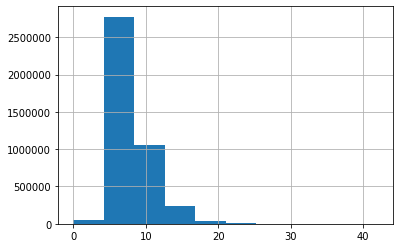

In [32]:
%matplotlib inline
train_df.len.hist()

(array([3.000000e+01, 4.000000e+00, 0.000000e+00, 4.000000e+00,
        0.000000e+00, 4.381000e+03, 2.774810e+05, 0.000000e+00,
        4.028110e+05, 0.000000e+00, 2.038823e+06, 1.333842e+06,
        0.000000e+00, 2.348416e+06, 0.000000e+00, 5.471520e+05,
        3.765110e+05, 0.000000e+00, 2.110400e+05, 0.000000e+00,
        1.529830e+05, 1.089100e+05, 0.000000e+00, 6.150300e+04,
        0.000000e+00, 4.339700e+04, 3.203200e+04, 0.000000e+00,
        1.224600e+04, 0.000000e+00, 9.553000e+03, 5.992000e+03,
        0.000000e+00, 4.972000e+03, 0.000000e+00, 2.475000e+03,
        1.791000e+03, 0.000000e+00, 1.027000e+03, 0.000000e+00,
        8.360000e+02, 4.380000e+02, 0.000000e+00, 3.620000e+02,
        0.000000e+00, 2.150000e+02, 2.050000e+02, 0.000000e+00,
        9.200000e+01, 0.000000e+00, 8.700000e+01, 3.000000e+01,
        0.000000e+00, 8.000000e+00, 0.000000e+00, 1.600000e+01,
        1.200000e+01, 0.000000e+00, 1.200000e+01, 0.000000e+00,
        1.000000e+01, 9.000000e+00, 0.00

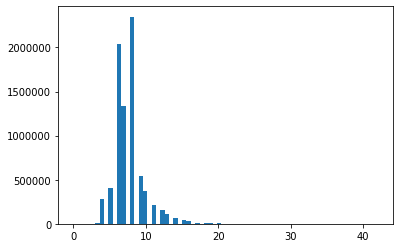

In [28]:
from matplotlib.pyplot import hist
hist(train_df.len, weights=train_df.Times, bins=70)

In [29]:
train_df.shape

(4151496, 123)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Times', 'Password'], axis=1), train_df['Times'], test_size=0.33)

In [45]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [46]:
from catboost import CatBoostRegressor

In [57]:
# model = CatBoostRegressor(iterations=1200,
#                             learning_rate=0.03,
#                             depth=4,
#                             loss_function='RMSE',
#                             eval_metric='RMSE',
#                             random_seed=99,
#                             od_type='Iter',
#                             od_wait=50)
model = CatBoostRegressor()
model.fit(X_train, y_train)

0:	learn: 38.4077626	total: 316ms	remaining: 5m 15s
1:	learn: 38.3924283	total: 630ms	remaining: 5m 14s
2:	learn: 38.3382322	total: 949ms	remaining: 5m 15s
3:	learn: 38.3245926	total: 1.26s	remaining: 5m 14s
4:	learn: 38.3127077	total: 1.62s	remaining: 5m 22s
5:	learn: 38.2824285	total: 1.97s	remaining: 5m 26s
6:	learn: 38.2615522	total: 2.22s	remaining: 5m 14s
7:	learn: 38.2510082	total: 2.57s	remaining: 5m 18s
8:	learn: 38.2339930	total: 2.87s	remaining: 5m 16s
9:	learn: 38.2246973	total: 3.18s	remaining: 5m 14s
10:	learn: 38.2039206	total: 3.48s	remaining: 5m 12s
11:	learn: 38.1938043	total: 3.77s	remaining: 5m 10s
12:	learn: 37.9959208	total: 4.14s	remaining: 5m 14s
13:	learn: 37.8009181	total: 4.48s	remaining: 5m 15s
14:	learn: 37.7926644	total: 4.78s	remaining: 5m 13s
15:	learn: 37.7841974	total: 5.07s	remaining: 5m 11s
16:	learn: 37.7784539	total: 5.33s	remaining: 5m 8s
17:	learn: 37.7711352	total: 5.6s	remaining: 5m 5s
18:	learn: 37.5818221	total: 5.96s	remaining: 5m 7s
19:	lea

155:	learn: 33.5745615	total: 45.7s	remaining: 4m 7s
156:	learn: 33.5733741	total: 46s	remaining: 4m 6s
157:	learn: 33.5724989	total: 46.2s	remaining: 4m 6s
158:	learn: 33.5713821	total: 46.6s	remaining: 4m 6s
159:	learn: 33.4673543	total: 46.9s	remaining: 4m 6s
160:	learn: 33.4663343	total: 47.1s	remaining: 4m 5s
161:	learn: 33.4654326	total: 47.4s	remaining: 4m 4s
162:	learn: 33.4637081	total: 47.6s	remaining: 4m 4s
163:	learn: 33.4631034	total: 47.8s	remaining: 4m 3s
164:	learn: 33.3764291	total: 48.1s	remaining: 4m 3s
165:	learn: 33.3755080	total: 48.4s	remaining: 4m 3s
166:	learn: 33.3740380	total: 48.7s	remaining: 4m 3s
167:	learn: 33.3730882	total: 49s	remaining: 4m 2s
168:	learn: 33.2548176	total: 49.4s	remaining: 4m 2s
169:	learn: 33.2489019	total: 49.6s	remaining: 4m 2s
170:	learn: 33.2403276	total: 49.9s	remaining: 4m 1s
171:	learn: 33.2388181	total: 50.2s	remaining: 4m 1s
172:	learn: 33.2380504	total: 50.4s	remaining: 4m
173:	learn: 33.2297976	total: 50.6s	remaining: 4m
174

307:	learn: 30.5473199	total: 1m 29s	remaining: 3m 21s
308:	learn: 30.4844349	total: 1m 30s	remaining: 3m 21s
309:	learn: 30.4232084	total: 1m 30s	remaining: 3m 21s
310:	learn: 30.3635432	total: 1m 30s	remaining: 3m 20s
311:	learn: 30.3559581	total: 1m 30s	remaining: 3m 20s
312:	learn: 30.3485998	total: 1m 31s	remaining: 3m 20s
313:	learn: 30.3468160	total: 1m 31s	remaining: 3m 19s
314:	learn: 30.2884223	total: 1m 31s	remaining: 3m 19s
315:	learn: 30.2869424	total: 1m 32s	remaining: 3m 19s
316:	learn: 30.2866666	total: 1m 32s	remaining: 3m 19s
317:	learn: 30.2764337	total: 1m 32s	remaining: 3m 18s
318:	learn: 30.2752694	total: 1m 32s	remaining: 3m 18s
319:	learn: 30.2741425	total: 1m 33s	remaining: 3m 18s
320:	learn: 30.2735841	total: 1m 33s	remaining: 3m 17s
321:	learn: 30.2165270	total: 1m 33s	remaining: 3m 17s
322:	learn: 30.2155078	total: 1m 34s	remaining: 3m 17s
323:	learn: 30.1593746	total: 1m 34s	remaining: 3m 17s
324:	learn: 30.1504410	total: 1m 34s	remaining: 3m 16s
325:	learn

458:	learn: 28.7740871	total: 2m 13s	remaining: 2m 37s
459:	learn: 28.7667437	total: 2m 13s	remaining: 2m 36s
460:	learn: 28.7662356	total: 2m 13s	remaining: 2m 36s
461:	learn: 28.7656840	total: 2m 14s	remaining: 2m 36s
462:	learn: 28.7645974	total: 2m 14s	remaining: 2m 36s
463:	learn: 28.7642868	total: 2m 14s	remaining: 2m 35s
464:	learn: 28.7456018	total: 2m 15s	remaining: 2m 35s
465:	learn: 28.7437299	total: 2m 15s	remaining: 2m 35s
466:	learn: 28.7429831	total: 2m 15s	remaining: 2m 34s
467:	learn: 28.7353533	total: 2m 16s	remaining: 2m 34s
468:	learn: 28.7057868	total: 2m 16s	remaining: 2m 34s
469:	learn: 28.7056026	total: 2m 16s	remaining: 2m 34s
470:	learn: 28.7049915	total: 2m 16s	remaining: 2m 33s
471:	learn: 28.7047316	total: 2m 17s	remaining: 2m 33s
472:	learn: 28.6975549	total: 2m 17s	remaining: 2m 33s
473:	learn: 28.6841290	total: 2m 17s	remaining: 2m 32s
474:	learn: 28.6834618	total: 2m 17s	remaining: 2m 32s
475:	learn: 28.6827717	total: 2m 18s	remaining: 2m 32s
476:	learn

608:	learn: 27.7886330	total: 2m 57s	remaining: 1m 53s
609:	learn: 27.7874732	total: 2m 57s	remaining: 1m 53s
610:	learn: 27.7673237	total: 2m 57s	remaining: 1m 53s
611:	learn: 27.7502332	total: 2m 58s	remaining: 1m 53s
612:	learn: 27.7494956	total: 2m 58s	remaining: 1m 52s
613:	learn: 27.7443938	total: 2m 58s	remaining: 1m 52s
614:	learn: 27.7393814	total: 2m 59s	remaining: 1m 52s
615:	learn: 27.7332777	total: 2m 59s	remaining: 1m 51s
616:	learn: 27.7326481	total: 2m 59s	remaining: 1m 51s
617:	learn: 27.7318932	total: 3m	remaining: 1m 51s
618:	learn: 27.7258568	total: 3m	remaining: 1m 50s
619:	learn: 27.7254046	total: 3m	remaining: 1m 50s
620:	learn: 27.7116673	total: 3m	remaining: 1m 50s
621:	learn: 27.7066117	total: 3m 1s	remaining: 1m 50s
622:	learn: 27.7058782	total: 3m 1s	remaining: 1m 49s
623:	learn: 27.7009158	total: 3m 1s	remaining: 1m 49s
624:	learn: 27.6991812	total: 3m 2s	remaining: 1m 49s
625:	learn: 27.6807069	total: 3m 2s	remaining: 1m 49s
626:	learn: 27.6800805	total: 3

758:	learn: 27.1928464	total: 3m 42s	remaining: 1m 10s
759:	learn: 27.1864685	total: 3m 42s	remaining: 1m 10s
760:	learn: 27.1858871	total: 3m 43s	remaining: 1m 10s
761:	learn: 27.1856151	total: 3m 43s	remaining: 1m 9s
762:	learn: 27.1779697	total: 3m 43s	remaining: 1m 9s
763:	learn: 27.1737769	total: 3m 44s	remaining: 1m 9s
764:	learn: 27.1696080	total: 3m 44s	remaining: 1m 8s
765:	learn: 27.1686099	total: 3m 44s	remaining: 1m 8s
766:	learn: 27.1682417	total: 3m 45s	remaining: 1m 8s
767:	learn: 27.1619517	total: 3m 45s	remaining: 1m 8s
768:	learn: 27.1556974	total: 3m 45s	remaining: 1m 7s
769:	learn: 27.1552885	total: 3m 45s	remaining: 1m 7s
770:	learn: 27.1493471	total: 3m 46s	remaining: 1m 7s
771:	learn: 27.1487715	total: 3m 46s	remaining: 1m 6s
772:	learn: 27.1485358	total: 3m 46s	remaining: 1m 6s
773:	learn: 27.1424183	total: 3m 47s	remaining: 1m 6s
774:	learn: 27.1420290	total: 3m 47s	remaining: 1m 6s
775:	learn: 27.1410082	total: 3m 47s	remaining: 1m 5s
776:	learn: 27.1369421	to

911:	learn: 26.8280265	total: 4m 29s	remaining: 26s
912:	learn: 26.8262166	total: 4m 29s	remaining: 25.7s
913:	learn: 26.8247966	total: 4m 29s	remaining: 25.4s
914:	learn: 26.8182826	total: 4m 30s	remaining: 25.1s
915:	learn: 26.8158757	total: 4m 30s	remaining: 24.8s
916:	learn: 26.8157956	total: 4m 30s	remaining: 24.5s
917:	learn: 26.8134366	total: 4m 31s	remaining: 24.2s
918:	learn: 26.8100522	total: 4m 31s	remaining: 23.9s
919:	learn: 26.8094419	total: 4m 31s	remaining: 23.6s
920:	learn: 26.8064038	total: 4m 31s	remaining: 23.3s
921:	learn: 26.8059979	total: 4m 32s	remaining: 23s
922:	learn: 26.8056513	total: 4m 32s	remaining: 22.7s
923:	learn: 26.8054814	total: 4m 32s	remaining: 22.4s
924:	learn: 26.8025424	total: 4m 33s	remaining: 22.1s
925:	learn: 26.8015134	total: 4m 33s	remaining: 21.9s
926:	learn: 26.8010560	total: 4m 33s	remaining: 21.6s
927:	learn: 26.7987327	total: 4m 34s	remaining: 21.3s
928:	learn: 26.7965026	total: 4m 34s	remaining: 21s
929:	learn: 26.7957922	total: 4m 3

In [69]:
y = model.predict(X_test)

In [70]:
new_y = []
for i in y:
    if i < 1:
        i = 1
    new_y.append(i)

In [52]:
# from sklearn.metrics import mean_squared_log_error
# np.sqrt(mean_squared_log_error(y_test, new_y))

0.4109889511798096

In [ ]:
#real 0.41335

In [61]:
# from sklearn.metrics import mean_squared_log_error
# np.sqrt(mean_squared_log_error(y_test, new_y))

0.4041143945970808

In [ ]:
#real 0.40652

In [71]:
# from sklearn.metrics import mean_squared_log_error
# np.sqrt(mean_squared_log_error(y_test, new_y))

0.40424963014549037

In [75]:
from lightgbm import LGBMRegressor

In [46]:
model = LGBMRegressor(num_leaves=45, max_depth=15) #num_leaves=31 max_depth=-1 learning_rate=0.1 learning_rate=0.005 is shit
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=45, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [47]:
y = model.predict(X_test)
new_y = []
for i in y:
    if i < 1:
        i = 1
    new_y.append(i)

In [82]:
# from sklearn.metrics import mean_squared_log_error
# np.sqrt(mean_squared_log_error(y_test, new_y))

0.38499128483537004

In [9]:
# import numpy as np
# from sklearn.metrics import mean_squared_log_error
# np.sqrt(mean_squared_log_error(y_test, new_y))

0.3834416936213631

In [13]:
# model.booster_.save_model('1.pkl')
# #bst = lgb.Booster(model_file='mode.txt')

In [25]:
# import numpy as np
# from sklearn.metrics import mean_squared_log_error
# np.sqrt(mean_squared_log_error(y_test, new_y))

0.38298501295529447

In [26]:
# model.booster_.save_model('2.pkl')

In [29]:
# import numpy as np
# from sklearn.metrics import mean_squared_log_error
# np.sqrt(mean_squared_log_error(y_test, new_y))

0.3809481758193047

In [30]:
# model.booster_.save_model('3.pkl')

In [48]:
import numpy as np
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(y_test, new_y))

0.38371805311021173

In [83]:
result_df = pd.DataFrame(model.predict(test_df.drop(['Password', 'Id'], axis=1)))
result_df = result_df.join(test_df['Id'])
result_df.columns = ['Times', 'Id']

In [84]:
result_df['Times'] = result_df['Times'].apply(lambda x: 1 if x < 1 else x)

In [64]:
# result_df[['Id', 'Times']].to_csv('new_approach4.csv', index=False)

In [ ]:
#0.40652 !!!

In [85]:
result_df[['Id', 'Times']].to_csv('new_approach5.csv', index=False)

In [ ]:
#0.38708

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [99]:
# params = {'boosting_type': 'gbdt',
#           'max_depth' : -1,
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 64,
#           'learning_rate': 0.05,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 1,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 5,
#           'reg_lambda': 10,
#           'min_split_gain': 0.5,
#           'min_child_weight': 1,
#           'min_child_samples': 5,
#           'scale_pos_weight': 1,}

# # Create parameters to search
# gridParams = {
#     'learning_rate': [0.005, 0.05, 0.1],
#     'n_estimators': [40, 100],
#     'num_leaves': [16,31],
#     'boosting_type' : ['gbdt'],
#     'random_state' : [501], # Updated from 'seed'
#     'colsample_bytree' : [0.85, 1],
#     'subsample' : [0.7, 1],
#     'reg_alpha' : [0,1.2],
#     'reg_lambda' : [0,1.4],
#     }


# # Create classifier to use. Note that parameters have to be input manually
# # not as a dict!
# mdl = LGBMRegressor(boosting_type= 'gbdt',
#           n_jobs = -1, # Updated from 'nthread'
#           silent = True,
#           max_depth = params['max_depth'],
#           max_bin = params['max_bin'],
#           subsample_for_bin = params['subsample_for_bin'],
#           subsample = params['subsample'],
#           subsample_freq = params['subsample_freq'],
#           min_split_gain = params['min_split_gain'],
#           min_child_weight = params['min_child_weight'],
#           min_child_samples = params['min_child_samples'],
#           scale_pos_weight = params['scale_pos_weight'])

# # To view the default model params:
# mdl.get_params().keys()

# # Create the grid
# grid = GridSearchCV(mdl, gridParams,
#                     verbose=10,
#                     cv=5,
#                     n_jobs=2)

In [101]:
# # Run the grid
# grid.fit(train_df.drop(['Times', 'Password'], axis=1), train_df['Times'])

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   48.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  6.8min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 11.5min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 14.1min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 17.8min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 21.1min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 25.8min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 31.7min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 38.6min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 45.8min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 54.8min
[Parallel(

{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.005, 'n_estimators': 100, 'num_leaves': 16, 'random_state': 501, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}
0.027964532670251202


In [6]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.005, 0.05, 0.1],
    'n_estimators': [40, 100],
    'num_leaves': [16,31],
    'boosting_type' : ['gbdt'],
#    'random_state' : [501], # 501 is shit
    'colsample_bytree' : [0.85, 1],
    'subsample' : [0.7, 1],
    'reg_alpha' : [0,1.2],
    'reg_lambda' : [0,1.4],
    }


# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = LGBMRegressor(boosting_type= 'gbdt',
          n_jobs = -1, 
          silent = True)



# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=10,
                    cv=5,
                    n_jobs=-1)

In [ ]:
# train_df.to_csv('my_train.csv', index=False)

In [119]:
# train_df.to_csv('my_train_sep.csv', sep='|', index=False)

In [120]:
# test_df.to_csv('my_test.csv', index=False)
# test_df.to_csv('my_test_sep.csv', sep='|', index=False)

In [2]:
train_df = pd.read_csv('my_train_sep.csv', sep='|')

In [3]:
test_df = pd.read_csv('my_test_sep.csv', sep='|')

In [ ]:
# Run the grid
grid.fit(train_df.drop(['Times', 'Password'], axis=1), train_df['Times'])

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [103]:
# model = LGBMRegressor(**grid.best_params_)
# model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              importance_type='split', learning_rate=0.005, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=16, objective=None,
              random_state=501, reg_alpha=0, reg_lambda=0, silent=True,
              subsample=1, subsample_for_bin=200000, subsample_freq=0)

In [104]:
# y = model.predict(X_test)
# new_y = []
# for i in y:
#     if i < 1:
#         i = 1
#     new_y.append(i)

In [105]:
# result_df = pd.DataFrame(model.predict(test_df.drop(['Password', 'Id'], axis=1)))
# result_df = result_df.join(test_df['Id'])
# result_df.columns = ['Times', 'Id']


In [106]:
# result_df['Times'] = result_df['Times'].apply(lambda x: 1 if x < 1 else x)

In [107]:
# result_df[['Id', 'Times']].to_csv('new_approach6.csv', index=False)

In [108]:
# result_df = pd.DataFrame(model.predict(test_df.drop(['Password', 'Id'], axis=1)))
# result_df = result_df.join(test_df['Id'])
# result_df.columns = ['Times', 'Id']

# result_df['Times'] = result_df['Times'].apply(lambda x: 1.265 if x < 1 else x)
# result_df[['Id', 'Times']].to_csv('new_approach7.csv', index=False)

In [109]:
# result_df = pd.DataFrame(model.predict(test_df.drop(['Password', 'Id'], axis=1)))
# result_df = result_df.join(test_df['Id'])
# result_df.columns = ['Times', 'Id']

# result_df['Times'] = result_df['Times'].apply(lambda x: 1.265 if x < 1.265 else x)
# result_df[['Id', 'Times']].to_csv('new_approach8.csv', index=False)

In [110]:
# 6 7 8 загрузить

In [ ]:
# model = LGBMRegressor(**grid.best_params_)

# result_df = pd.DataFrame(model.predict(test_df.drop(['Password', 'Id'], axis=1)))
# result_df = result_df.join(test_df['Id'])
# result_df.columns = ['Times', 'Id']
# result_df['Times'] = result_df['Times'].apply(lambda x: 1 if x < 1 else x)
# result_df[['Id', 'Times']].to_csv('new_approach9.csv', index=False)

In [114]:
# model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=40, n_jobs=-1, num_leaves=16, objective=None,
              random_state=501, reg_alpha=1.2, reg_lambda=0, silent=True,
              subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [50]:
import lightgbm as lgb

In [51]:
model = LGBMRegressor()
model = lgb.Booster(model_file='3.pkl')

result_df = pd.DataFrame(model.predict(test_df.drop(['Password', 'Id'], axis=1)))
result_df = result_df.join(test_df['Id'])
result_df.columns = ['Times', 'Id']
result_df['Times'] = result_df['Times'].apply(lambda x: 1 if x < 1 else x)
result_df[['Id', 'Times']].to_csv('new_approach10.csv', index=False)